In [1]:
import glob
import numpy as np 
import pandas as pd
import xgboost as xgb
from lfp_extracters import *
import matplotlib.pyplot as plt
from sklearn.cross_validation import ShuffleSplit

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

#### From numbers 0 to 200, randomly select 80% to be in the test data set. If the number is even, it is in the Stimulus A folder; if it is odd, it is in the Stimulus B folder.

In [2]:
def generate_inds(): 
    numIter = 5
    rs = ShuffleSplit(1200, n_iter=numIter, test_size=.2, random_state=0)
    
    A_files = glob.glob('data/data/Stimulus_A/LFP_15_300/*.csv')
    B_files = glob.glob('data/data/Stimulus_B/LFP_15_300/*.csv')
    files = np.array(A_files + B_files)
    
    train_inds = []
    test_inds = []
    for train, test in rs: 
        train_inds.append(train)
        test_inds.append(test)
        
    train2 = []
    val_inds = []
    for t in train_inds: 
        s = ShuffleSplit(len(t), n_iter = 1, test_size = .2, random_state = 0)
        for train, val in s: 
            train2.append(train)
            val_inds.append(val)
        
    train_inds = train2
        
    return numIter, train_inds, val_inds, test_inds, files

In [3]:
def get_train_test(trial_num, train_inds, test_inds, val_inds, files):
    train_files = files[train_inds[trial_num]]
    test_files = files[test_inds[trial_num]]
    val_files = files[val_inds[trial_num]]
    return train_files, test_files, val_files

#### Make Test Dataframe

In [4]:
def make_test_df(test_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    l = []
    y_test = []
    bin_width = int(bin_width)
    
    for i in range(len(test_files)):
        n1 = np.genfromtxt(test_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        l.append(n_new) 
        if 'A' in test_files[i]: 
            y_test = y_test + [0]
        else: 
            y_test = y_test + [1]

    return l, y_test

#### Make Train Dataframe

In [5]:
def make_train_df(train_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    
    list_ = []
    y_train = []
    bin_width = int(bin_width)
    
    for i in range(len(train_files)):
        n1 = np.genfromtxt(train_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        list_.append(n_new)
        if 'A' in train_files[i]: 
            y_train = y_train + [0]
        else: 
            y_train = y_train + [1]

    return list_, y_train

In [6]:
def make_val_df(val_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    
    list_ = []
    y_val = []
    bin_width = int(bin_width)
    
    for i in range(len(val_files)):
        n1 = np.genfromtxt(val_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        list_.append(n_new)
        if 'A' in val_files[i]: 
            y_val = y_val + [0]
        else: 
            y_val = y_val + [1]

    return list_, y_val

### Threshold Crossing Rate

In [7]:
def threshold_crossing_rate(x, threshold, bin_width): 
    #apply this within train and test data production
    inds = range(0, 6001, int(bin_width))
    hastime = len(x) == 17
    newx = []
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        count_above = np.sum(abs(np.diff(sub > threshold)), axis = 1)/float(bin_width)
        if hastime:
            t_seg = np.reshape(t[inds[i]], (1,)) #uses time stamp at beginning of each bin
            count_above = np.concatenate((count_above, t_seg))
        newx.append(count_above)
    return np.array(newx)

### RMS

In [8]:
def root_mean_square(x, threshold, bin_width): 
    inds = range(0, 6001, bin_width)
    hastime = len(x) == 17
    newx = []
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        rms = np.sqrt(np.mean(sub**2, axis = 1)) 
        
        if hastime: 
            t_seg = np.reshape(t[inds[i]], (1,))
            rms = np.concatenate((rms, t_seg))
        newx.append(rms)
    return np.array(newx)

### RMS in Gamma Band

In [9]:
def power_gamma_band(x, threshold, bin_width): 
    inds = range(0, 6001, bin_width)
    hastime = len(x) == 17
    newx = [] 
    #make bandpass filter for 30-100Hz 
    fs = 6000
    nyq = 0.5 * fs
    cutOff_L = 30
    cutOff_H = 100
    low = cutOff_L / nyq
    high = cutOff_H / nyq
    order = 2
    b, a = signal.butter(order, [low, high], btype='band')
    
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        sub_f = signal.lfilter(b, a, sub)
        rms = np.sqrt(np.mean(sub**2, axis = 1))
        if hastime: 
            t_seg = np.reshape(t[inds[i]], (1,))
            rms = np.concatenate((rms, t_seg))
        newx.append(rms)
    return np.array(newx)

In [10]:
def no_change(x, threshold, bin_width): 
    return x

## Create XGBoost Classifiers

In [28]:
def fit(val_df, train_df, test_df, y_val, y_train, y_test):

    max_depth = 3
    eval_set = [(train_df, y_train), (val_df, y_val)] 
    xg = xgb.XGBClassifier(
                            objective = 'binary:logistic',
                            learning_rate = 0.1,
                            seed = 2925, 
                            max_depth = max_depth
                            )
    bst2 = xg.fit(train_df, np.array(y_train), 
                  eval_metric= "logloss", 
                  eval_set= eval_set,
                  early_stopping_rounds = 10) 
    return bst2 

In [12]:
def predict(bst, test_df): 
    y_test_predicted = bst.predict(np.array(test_df))
    return y_test_predicted

## Main

In [33]:
def main(): 
    with_time = False
    threshold = 0.010 
    bin_width = 265 
    bin_function = power_gamma_band 
    accuracies = {} 
    counter = 1

    numIters, train_inds, val_inds, test_inds, files = generate_inds()
    y_predicted = []
    y_actual = []
    for i in range(numIters): 
        print('Iteration ' + str(i+1) + ' of ' + str(numIters))
        train_files, test_files, val_files = get_train_test(i, train_inds, test_inds, val_inds, files)
        test_df, y_test = make_test_df(test_files, with_time, bin_function, threshold, bin_width)
        train_df, y_train = make_train_df(train_files, with_time, bin_function, threshold, bin_width)
        val_df, y_val = make_val_df(val_files, with_time, bin_function, threshold, bin_width)
        train_df = np.array(train_df)
        test_df = np.array(test_df)
        val_df = np.array(val_df)
        
        if with_time: 
            all_times = np.concatenate((train_df[:,:,-1], test_df[:,:,-1], val_df[:,:,-1])) 
            overall_time_mean = all_times.mean()
            overall_time_std = all_times.std() * 100
            new_times_train = (train_df[:,:,-1]-overall_time_mean)/overall_time_std
            new_times_test = (test_df[:,:,-1]-overall_time_mean)/overall_time_std
            new_times_val = (val_df[:,:,-1]-overall_time_mean)/overall_time_std
            train_df[:,:,-1] = new_times_train
            test_df[:,:,-1] = new_times_test
            val_df[:,:,-1] = new_times_val
            
        if with_time: 
            test_df = np.reshape(test_df, (240,(6000//bin_width)*17,))
            train_df = np.reshape(train_df, (768,(6000//bin_width)*17,))
            val_df = np.reshape(val_df, (192,(6000//bin_width)*17,))
        else: 
            test_df = np.reshape(test_df, (240,(6000//bin_width)*16,)) 
            train_df = np.reshape(train_df, (768,(6000//bin_width)*16,)) 
            val_df = np.reshape(val_df, (192,(6000//bin_width)*16,)) 
        
        y_actual.append(y_test)

        print('Fitting...')
        bst2 = fit(val_df, train_df, test_df, np.transpose(y_val), np.transpose(y_train), np.transpose(y_test))
        print('Predicting...')
        y_test_predicted = predict(bst2, test_df)
        y_predicted.append(y_test_predicted)

    y_predicted = np.round(y_predicted)
    accs = []
    for j in range(0, len(y_predicted)): 
        p = y_predicted[j]
        a = y_actual[j]
        acc = np.sum(np.array(a) == np.array(p)) / float(len(a))
        accs.append(acc)
        print('Accuracy for iteration ' + str(j+1) + ': ' + str(acc))
    n = (np.mean(accs), np.std(accs)) #tuple of mean accuracy, standard dev 
    accuracies[bin_width] = n

    counter += 1

    return accuracies, bst2

In [34]:
if __name__ == '__main__':
    accuracies, bst2 = main()

Iteration 1 of 5
Fitting...
[0]	validation_0-logloss:0.653848	validation_1-logloss:0.664722
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.620509	validation_1-logloss:0.638646
[2]	validation_0-logloss:0.590272	validation_1-logloss:0.62179
[3]	validation_0-logloss:0.564219	validation_1-logloss:0.607073
[4]	validation_0-logloss:0.541591	validation_1-logloss:0.592134
[5]	validation_0-logloss:0.521125	validation_1-logloss:0.582791
[6]	validation_0-logloss:0.503028	validation_1-logloss:0.573296
[7]	validation_0-logloss:0.484766	validation_1-logloss:0.564411
[8]	validation_0-logloss:0.469974	validation_1-logloss:0.556335
[9]	validation_0-logloss:0.45489	validation_1-logloss:0.54936
[10]	validation_0-logloss:0.441189	validation_1-logloss:0.544462
[11]	validation_0-logloss:0.427927	validation_1-logloss:0.538298
[12]	validation_0-logloss:0.414021	valid

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting...
[0]	validation_0-logloss:0.653848	validation_1-logloss:0.664722
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.620509	validation_1-logloss:0.638646
[2]	validation_0-logloss:0.590272	validation_1-logloss:0.62179
[3]	validation_0-logloss:0.564219	validation_1-logloss:0.607073
[4]	validation_0-logloss:0.541591	validation_1-logloss:0.592134
[5]	validation_0-logloss:0.521125	validation_1-logloss:0.582791
[6]	validation_0-logloss:0.503028	validation_1-logloss:0.573296
[7]	validation_0-logloss:0.484766	validation_1-logloss:0.564411
[8]	validation_0-logloss:0.469974	validation_1-logloss:0.556335
[9]	validation_0-logloss:0.45489	validation_1-logloss:0.54936
[10]	validation_0-logloss:0.441189	validation_1-logloss:0.544462
[11]	validation_0-logloss:0.427927	validation_1-logloss:0.538298
[12]	validation_0-logloss:0.414021	validation_1-logloss:0

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting...
[0]	validation_0-logloss:0.653848	validation_1-logloss:0.664722
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.620509	validation_1-logloss:0.638646
[2]	validation_0-logloss:0.590272	validation_1-logloss:0.62179
[3]	validation_0-logloss:0.564219	validation_1-logloss:0.607073
[4]	validation_0-logloss:0.541591	validation_1-logloss:0.592134
[5]	validation_0-logloss:0.521125	validation_1-logloss:0.582791
[6]	validation_0-logloss:0.503028	validation_1-logloss:0.573296
[7]	validation_0-logloss:0.484766	validation_1-logloss:0.564411
[8]	validation_0-logloss:0.469974	validation_1-logloss:0.556335
[9]	validation_0-logloss:0.45489	validation_1-logloss:0.54936
[10]	validation_0-logloss:0.441189	validation_1-logloss:0.544462
[11]	validation_0-logloss:0.427927	validation_1-logloss:0.538298
[12]	validation_0-logloss:0.414021	validation_1-logloss:0

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting...
[0]	validation_0-logloss:0.653848	validation_1-logloss:0.664722
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.620509	validation_1-logloss:0.638646
[2]	validation_0-logloss:0.590272	validation_1-logloss:0.62179
[3]	validation_0-logloss:0.564219	validation_1-logloss:0.607073
[4]	validation_0-logloss:0.541591	validation_1-logloss:0.592134
[5]	validation_0-logloss:0.521125	validation_1-logloss:0.582791
[6]	validation_0-logloss:0.503028	validation_1-logloss:0.573296
[7]	validation_0-logloss:0.484766	validation_1-logloss:0.564411
[8]	validation_0-logloss:0.469974	validation_1-logloss:0.556335
[9]	validation_0-logloss:0.45489	validation_1-logloss:0.54936
[10]	validation_0-logloss:0.441189	validation_1-logloss:0.544462
[11]	validation_0-logloss:0.427927	validation_1-logloss:0.538298
[12]	validation_0-logloss:0.414021	validation_1-logloss:0

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting...
[0]	validation_0-logloss:0.653848	validation_1-logloss:0.664722
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.620509	validation_1-logloss:0.638646
[2]	validation_0-logloss:0.590272	validation_1-logloss:0.62179
[3]	validation_0-logloss:0.564219	validation_1-logloss:0.607073
[4]	validation_0-logloss:0.541591	validation_1-logloss:0.592134
[5]	validation_0-logloss:0.521125	validation_1-logloss:0.582791
[6]	validation_0-logloss:0.503028	validation_1-logloss:0.573296
[7]	validation_0-logloss:0.484766	validation_1-logloss:0.564411
[8]	validation_0-logloss:0.469974	validation_1-logloss:0.556335
[9]	validation_0-logloss:0.45489	validation_1-logloss:0.54936
[10]	validation_0-logloss:0.441189	validation_1-logloss:0.544462
[11]	validation_0-logloss:0.427927	validation_1-logloss:0.538298
[12]	validation_0-logloss:0.414021	validation_1-logloss:0

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Plot Learning Curves

In [25]:
results = bst2.evals_result()
train = results['validation_0']['logloss']
val = results['validation_1']['logloss']

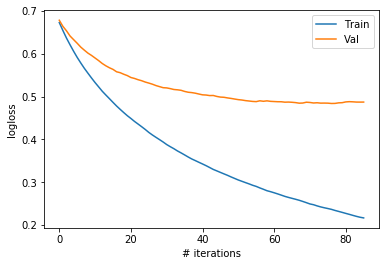

In [26]:
plt.plot(train)
plt.plot(val)
plt.xlabel('# iterations')
plt.ylabel('logloss')
plt.legend(['Train','Val','Test'])
plt.show()

In [36]:
accuracies

{265: (0.8608333333333335, 0.020172864061516988)}